This prototype replicates the approach adopted by Ciftci, Demir & Yin in their paper Synthetic Portrait Videos using Biological Signals. We use the facenet-pytorch package to build a rudimentary deepfake detector without training any models. It also demonstrates a method for (1) loading all video frames, (2) finding all faces, and (3) calculating face embeddings at over 30 frames per second (or greater than 1 video per 10 seconds).
The following steps are performed: 
1. Create pretrained facial detection (MTCNN) and recognition (Inception Resnet) models.
2. For each test video, calculate face feature vectors for ALL faces in each video.
3. Calculate the distance from each face to the centroid for its video.
4. Use these distances as your means of discrimination.
5. For (much) better results, finetune the resnet to the fake/real binary classification task instead.

In [24]:
import os
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()
import seaborn as sns
# use the face detection pre-trained model from pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
#print wether I am using CPU or CUDA– used for Google Collab
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


In [26]:
sns.set()

In [7]:
#load the pre-trained model 
mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()
# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

# Process Test Videos
After defining a few helper functions, this code loops through all videos and passes all frames from each through the face detector followed by facenet. Finally, we calculate the distance from the centroid to the extracted feature for each face

In [8]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces    


def process_faces(faces, resnet):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return x

# Predict classes
The below weights were selected by following the same process as above for the train sample videos and then using a logistic regression model to fit to the labels. Note that, intuitively, this is not a very good approach as it does nothing to take into account the progression of feature vectors throughout a video, just combines them together using the weights below. This step is provided as a placeholder only; it should be replaced with a more thoughtful mapping from a sequence of feature vectors to a single prediction.

In [17]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=0.25)

# Get all test videos
filenames = glob.glob('/Users/asmaaaly/Downloads/test_videos/test_final/*.mp4')

X = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(filenames), total=len(filenames)):
        try:
            # Load frames and find faces
            faces = detection_pipeline(filename)
            
            # Calculate embeddings
            X.append(process_faces(faces, resnet))

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
            X.append(None)
        
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

Frames per second (load+detect+embed):  0.375


In [18]:
bias = -0.2942
weight = 0.68235746

results = []
for filename, x_i in zip(filenames, X):
    if x_i is not None:
        prob = 1 / (1 + np.exp(-(bias + (weight * x_i).mean())))
    else:
        prob = 0.5
    results.append([os.path.basename(filename), prob])

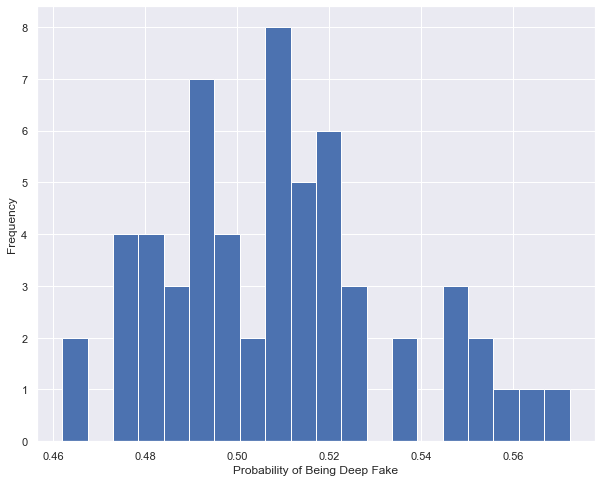

In [35]:
results = pd.DataFrame(results, columns=['filename', 'label'])
plt.figure(figsize=(10,8))
plt.hist(results.label, 20)
plt.xlabel("Probability of Being Deep Fake")
plt.ylabel("Frequency")

plt.show()